# D.3. Optimization - Constraints

## Module: Risk

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

# Import Packages, Settings

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns
#import statsmodels.api as sm

In [3]:
import os
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

# Import and Organize Data
### Data Source: Yahoo Finance

In [4]:
DATAFILE = '../data/multi_asset_etf_data.xlsx'

TICKER_CASH = 'SHV'
DROP_CASH = False

info = pd.read_excel(DATAFILE,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(DATAFILE,sheet_name='total returns')
rets.set_index('Date',inplace=True)
if DROP_CASH:
    rets.drop(columns=['SHV'])

retsx = pd.read_excel(DATAFILE,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
if DROP_CASH:
    symbol_list = info.index.drop('SHV')
else:
    symbol_list = info.index
    
rets = rets[symbol_list]
retsx = retsx[symbol_list.drop('SHV')]

In [5]:
info['Name'] = ['Domestic Equity','Foreign Equity','Emerging Markets','Private Equity','Absolute Return','High Yield','Commodities','Real Estate','Domestic Bonds','Foreign Bonds','Inflation-Indexed Bonds','Cash']
display(info)

,ETF Description,Name
Symbol,,
SPY,Domestic Equity SPDR S&P500,Domestic Equity
EFA,Foreign Equity iShares EAFE,Foreign Equity
EEM,iShares Emerging Markets,Emerging Markets
PSP,Private Equity Invesco Global Private Equity,Private Equity
QAI,Absolute Return IQ Multi-Strat,Absolute Return
HYG,High Yield iShares High Yield Corporate Bond,High Yield
DBC,Invesco DB Commodity Index Tracking Fund,Commodities
IYR,Real Estate iShares US Real Estate,Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury,Domestic Bonds


In [6]:
USE_LONGONLY_CONSTRAINT = False
TARGET_MEAN = 0.10

USE_EXCESS = False
SCALE_ANNUAL = 12

if USE_EXCESS:
    df_data = retsx
else:
    df_data = rets

df_data.columns = info['Name']
CASH = 'Cash'

mean = df_data.mean() * SCALE_ANNUAL
cov = df_data.cov()* SCALE_ANNUAL
nAssets = df_data.shape[1]
        
bounds_df = pd.DataFrame(index=df_data.columns,columns=['Min','Max'],dtype=float)

if USE_LONGONLY_CONSTRAINT:
    bounds_df['Min'] = 0
    bounds_df['Max'] = 10
else:
    # Add more specific bounds here if desired
    bounds_df['Min'] = -.05
    bounds_df['Max'] = .50
#    bounds_df.loc[['Domestic Equity','Foreign Equity','Private Equity'],'Min'] = [.25,0,0]

# Constrained Optimization

### Objective
Minimize portfolio variance. 
- Portfolio weights: $\boldsymbol{w}$
- Return covariance matrix: $\boldsymbol{\Sigma}$
$$f(\boldsymbol{w}) = \boldsymbol{w}' \boldsymbol{\Sigma} \boldsymbol{w}$$

In [7]:
def objective(w):        
    return (w.T @ cov @ w)

### Constraints

#### Equality Constraints
- Targeted mean for the optimized portfolio: $\mu_p$
Define the following two functions:
$$g_{1}(\boldsymbol{w}) \equiv \boldsymbol{1}'\boldsymbol{w}$$
$$g_{2}(\boldsymbol{w}) \equiv \boldsymbol{\mu}'\boldsymbol{w}$$

These are imposed as equality constraints:
$$g_1(\boldsymbol{w}) = 1$$
$$g_2(\boldsymbol{w}) = \mu_p$$

#### Target mean
Below we analyze the problem for a target mean return of
- 8% if using the assume stats
- 12% if using the historic stats
The reason for the difference is that the historic stats are **much** more favorable, and it is easy to generate high mean returns.

In [8]:
def fun_constraint_capital(w):
    return np.sum(w) - 1

def fun_constraint_mean(w):
    return (mean @ w) - TARGET_MEAN

constraint_capital = {'type': 'eq', 'fun': fun_constraint_capital}
constraint_mean = {'type': 'eq', 'fun': fun_constraint_mean}

cons = ([constraint_capital, constraint_mean])

### Inequality Constraints

**This cell's notation and setup is overkill for the simplicity of these constraints, but is noted here for more general problems.**

- Denote the $k\times k$ identity matrix as $\mathcal{I}_k$
- Denote the $i$ column of the identity matrix as $\boldsymbol{\iota}_i$

Define the following $k$ functions, for $1\le i\le n$: 
$$h_i(\boldsymbol{w}) \equiv \boldsymbol{\iota}_i' \boldsymbol{w}$$
For each $i$, we use the upper and lower inequality constraints:
$$h_i(\boldsymbol{w}) \le d_i^{\text{max}}$$
$$h_i(\boldsymbol{w}) \ge d_i^{\text{min}}$$

Stack the constraints into matrix notation. The inequality constraint functions are linear:
$$\boldsymbol{h}(\boldsymbol{w}) \equiv \mathcal{I}_k \boldsymbol{w}$$
and there are $2n$ total of them--$n$ upper and $n$ lower:
$$\boldsymbol{h}(\boldsymbol{w}) \le \boldsymbol{d}^{\text{max}}$$
$$\boldsymbol{h}(\boldsymbol{w}) \ge \boldsymbol{d}^{\text{min}}$$

### Boundary Constraints

Given that the inequality constraint functions are all linear, these constraints are simply boundary conditions.

The `scipy` package `minimize` implements boundary constraints specifically, via an iteration of tuples:

In [9]:
bounds = [tuple(bounds_df.iloc[i,:].values) for i in range(nAssets)]

## Solution

#### Default Tolerance
- Default tolerance is fine here, but be careful. Variance minimization for daily or even monthly variance leads to extremely small scaling of the objective function, and often the default tolerance will not be sufficient.
- Even in the example below, making the tolerance stricter impacts the weights to the second decimal place.

#### Method
- For the data given here the problem is not too hard to solve, so many methods will work fine.
- If using high dimensionality, nearly singular determinant, etc, it may matter more.
- Below we use `SLSQP` as it is fast and fairly robust for this application.
- At the end, we redo the optimization using `trust-constr` solely for the fact that this method automatically returns the Lagrange Multipliers which are useful for pedagogical reasons.

#### Initialize
- Try equally-weighted portfolio
- This satisfies the Long-Only constraint.
- May not satisfy the Policy constraint, but this problem is well-behaved, so it will be good enough as an initial guess

#### Verify!
- In a serious application, we would code the problem to verify that the answer returned by the solution is a "success" (obeys all the constraints) rather than a failed attempt. Try changing `TARGET_MEAN` to a big number, and you will see the optimizer fail to hit the target and obey the constraints.

In [10]:
TOL = 1e-12
METHOD = 'SLSQP'

w0 = np.ones(nAssets) / nAssets

solution = minimize(objective, w0, method=METHOD, bounds=bounds,constraints=cons, tol=TOL)
wstar = pd.DataFrame(data=solution.x, index=cov.columns, columns=['Bounded: Numerical'])

if solution.success:
    print('Optimization SUCCESSFUL.')
else:
    print('Optimization FAILED.')

print(f'Iterations: {solution.nit}.')

Optimization SUCCESSFUL.
Iterations: 35.


# Other Solutions for Comparison

#### HBS Case Exhibit Solution
Compare to Exhibits 5 and 6.
- Only applicable if `USE_HISTORIC_STATS` is `False`.
- (Case does not provide their solutions when using Historic data.)

#### Classic MV via Numerical Optimization
Solve numerically by dropping the inequality (bounds) constraints in `minimize`.
- Only applicable if `USE_HISTORIC_STATS` is `False`. 
- (Exhibit 2 correlation matrix is not positive definite.)

#### Analytic MV solution for verification.
- Calculate this on your own.
- The function doing it below is not available to you.
- If `USE_HISTORIC_STATS` is `True`, computation may not work correctly, but it is attempted.

#### Equal-weighted
- Just for illustration. 

In [11]:
METHOD = 'SLSQP'
TOL = 1e-12
w0 = np.ones(nAssets) / nAssets

solutionMV = minimize(objective, w0, method=METHOD, constraints=cons, tol=TOL)
wstar['MV: Numerical'] = solutionMV.x

if solutionMV.success:
    print('Optimization SUCCESSFUL.')
else:
    print('Optimization FAILED.')

print(f'Iterations: {solutionMV.nit}.')

Optimization SUCCESSFUL.
Iterations: 72.


In [12]:
if os.path.isfile('../dev/extras.py'):
    sys.path.insert(0, '../dev')
    from extras import MVweights
    wstar['MV: Analytic'] = MVweights(mean=mean,cov=cov,isexcess=False,target=TARGET_MEAN)
    
    DO_MV = True

In [13]:
wstar.insert(0,'Equally-Weighted',w0)

# Results

### Optimized Weights Comparison

In [14]:
display(wstar.style.format('{:.2%}'.format))

,Equally-Weighted,Bounded: Numerical,MV: Numerical,MV: Analytic
Name,,,,
Domestic Equity,8.33%,50.00%,66.96%,66.96%
Foreign Equity,8.33%,-5.00%,1.59%,1.59%
Emerging Markets,8.33%,-5.00%,3.84%,3.84%
Private Equity,8.33%,-5.00%,-10.18%,-10.18%
Absolute Return,8.33%,-5.00%,-130.87%,-130.87%
High Yield,8.33%,22.50%,37.78%,37.78%
Commodities,8.33%,-3.46%,6.74%,6.74%
Real Estate,8.33%,7.75%,-11.64%,-11.64%
Domestic Bonds,8.33%,50.00%,68.33%,68.33%


### Using Bounds of...

In [15]:
display(bounds_df.style.format('{:.2%}'.format))

,Min,Max
Name,,
Domestic Equity,-5.00%,50.00%
Foreign Equity,-5.00%,50.00%
Emerging Markets,-5.00%,50.00%
Private Equity,-5.00%,50.00%
Absolute Return,-5.00%,50.00%
High Yield,-5.00%,50.00%
Commodities,-5.00%,50.00%
Real Estate,-5.00%,50.00%
Domestic Bonds,-5.00%,50.00%


# Performance Stats

In [16]:
meanP = (mean.T @ wstar)
volP = pd.Series(np.diag(wstar.T @ cov @ wstar),index=wstar.columns).apply(np.sqrt)

sharpeP = (meanP-mean.loc[CASH])/volP

performance = pd.DataFrame({'mean':meanP,'vol':volP,'Sharpe':sharpeP})
display(performance.style.format('{:.2%}'.format))

,mean,vol,Sharpe
Equally-Weighted,6.88%,8.99%,71.40%
Bounded: Numerical,10.00%,6.82%,139.82%
MV: Numerical,10.00%,4.75%,200.79%
MV: Analytic,10.00%,4.75%,200.79%


### In the case of Assumed Statistics (Exhibit 4)...

The Bounded and Classic MV answers have similar Sharpe ratios.
- Bounded optimization does a good job?
- For these targeted mean returns, yes.
- But for large target mean, classic MV can get there with huge long-short positions, and the bounded solution will fail or will do so with bigger penalty.

Try `TARGET_MEAN` of 10%, 15%, 20% to get an idea of this.

Additionally, this analysis is impacted by the strange assumed mean return. Domestic equities are assumed to only have a 3% premium over cash!

# Which Constraints are most costly?

The Lagrange Multipliers give us a clue.
- Each is the derivative of the objective function with respect to the constraint boundary.
- Magnitude shows impact.
- Sign is an indication of whether constraint is upper or lower bound.
- Showing impact on objective (variance) so numbers are small.

Focus on their relative magnitudes.

### The importance of the constraints changes a lot
- between using the Long-Only or Policy Constraints
- between using the Historic and Assumed Stats

In [17]:
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

TOL = 1e-12
METHOD = 'trust-constr'

w0 = wstar['Bounded: Numerical']
solutionALT = minimize(objective, w0, method=METHOD, bounds=bounds,constraints=cons, tol=TOL)

pd.DataFrame(solutionALT.v[-1], index=mean.index, columns=['Lagrange Multipliers']).sort_values('Lagrange Multipliers',ascending=False).style.format('{:.4%}'.format)

,Lagrange Multipliers
Name,
Domestic Equity,0.4231%
Domestic Bonds,0.0132%
High Yield,-0.0000%
Real Estate,-0.0000%
Inflation-Indexed Bonds,-0.0000%
Commodities,-0.0000%
Cash,-0.1828%
Private Equity,-0.2675%
Foreign Equity,-0.3170%


# Figures

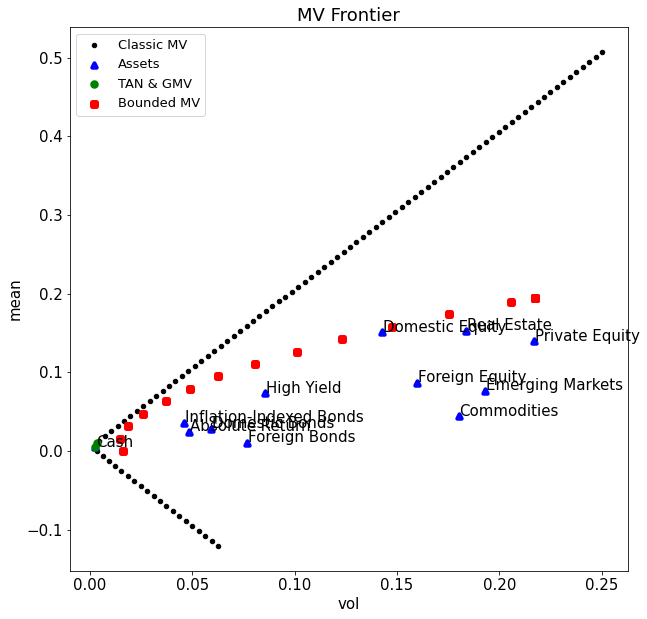

In [18]:
warnings.filterwarnings("ignore", message="Values in x were outside bounds during a ")

if DO_MV:
    omega = pd.DataFrame(MVweights(mean=mean,cov=cov,isexcess=False,target='TAN'), index=mean.index).rename({0:'Tangency'},axis=1)

    mean_ex = mean-mean[CASH]
    cov_ex = cov.drop(columns=[CASH],index=[CASH])
    omega['GMV'] = MVweights(mean=mean,cov=cov,isexcess=False,target='GMV')

    omega_tan = omega['Tangency']
    omega_gmv = omega['GMV']

    vols = pd.Series(np.sqrt(np.diag(cov)), index=cov.index)
    special_vols = pd.Series(np.sqrt(np.diag(omega.T @ cov @ omega)), index=omega.columns)
    special_means = mean.T @ omega

    if USE_LONGONLY_CONSTRAINT:
        MVgridmax = 60
    else:
        MVgridmax = 100

    delta_grid = np.linspace(-25,MVgridmax,100)
    mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
    for i, delta in enumerate(delta_grid):
        omega_mv = delta * omega_tan + (1-delta) * omega_gmv
        mv_frame['mean'].iloc[i] = omega_mv.T @ mean.T
        mv_frame['vol'].iloc[i] = np.sqrt(omega_mv.T @ cov @ omega_mv)

    mv_assets = pd.concat([mean, vols],axis=1)
    mv_special = pd.concat([special_means, special_vols],axis=1)
    mv_assets.columns = ['mean','vol']
    mv_special.columns = ['mean','vol']

    ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
    mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=4)
    mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='g', marker='o', linewidth=4)

    for i in range(mv_assets.shape[0]):
        plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.001, s=mv_assets.index[i])

    TOL = 1e-12
    METHOD = 'SLSQP'
    w0 = np.ones(nAssets) / nAssets


    if USE_LONGONLY_CONSTRAINT:
        maxmu = .20
        minmu = 0
    else:
        maxmu = .30
        minmu = .0

    mu_grid = np.linspace(minmu,maxmu,20)
    mvcon_frame = pd.DataFrame(columns=['mean','vol'],index=mu_grid)
    for i, mu in enumerate(mu_grid):
        TARGET_MEAN = mu
        omega_con = minimize(objective, w0, method=METHOD, bounds=bounds,constraints=cons, tol=TOL).x
        mvcon_frame['mean'].iloc[i] = omega_con.T @ mean.T
        mvcon_frame['vol'].iloc[i] = np.sqrt(omega_con.T @ cov @ omega_con)

    mvcon_frame.plot.scatter(x='vol',y='mean', c='r', marker = 's', ax=ax, linewidth=5)

    plt.legend(['Classic MV', 'Assets', 'TAN & GMV', 'Bounded MV'])
    full_fig = plt.gcf()

### Plot of Sharpe Ratio as short constraint varies
#### Holding target mean return fixed
This is the numerical equivalent to the LaGrangian constraints reported above.

<span style='color:red'>In development</span>